## Google Drive Connection

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
os.chdir('drive/My Drive/Colab Notebooks/Labeling')

# Import Libraries

In [3]:
# Import Libraries 
import itertools as itt
import numbers
import numpy as np
import pandas as pd
from abc import abstractmethod
from typing import Iterable, Tuple, List
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import xgboost as xgb
from prettytable import PrettyTable
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn import metrics
import seaborn as sns
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsRegressor

# Functions

## Labeling

In [10]:
# Labelling algorithm X is price and th is our threshould

def labeling(X, th):
    n = len(X)
    y = np.array([0 for i in range(n)])
    FP = X[0]
    xh = X[0]
    xl = X[0]
    HT = 0
    LT = 0
    cid = 0
    FP_N = 0
    for i in range(n):
        if(X[i] > FP + X[0]*th):
            xh, HT, FP_N, cid  = X[i], i, i, 1
            break
        if(X[i] < FP - X[0]*th):
            xh,HT,FP_N,cid  = X[i],i,i,-1
            break
    for i in range(FP_N+1,n):
        if(cid > 0):
            if(X[i]>xh):
                xh, HT = X[i], i
            if(X[i] < xh - xh * th and LT<= HT):
                for j in range(n):
                    if(j > LT and j <= HT):
                        y[j] = 1
                xl, LT, cid = X[i], i, -1
        if(cid < 0):
            if(X[i] < xl):
                xl, LT = X[i], i
            if(X[i] > xl + xl * th and HT <= LT):
                for j in range(n):
                    if(j > HT and j <= LT):
                        y[j] = 0
                xh, HT, cid = X[i], i, 1
    return y


In [11]:
# Implement Cross-validation methods

class BaseTimeSeriesCrossValidator:
    """
    Abstract class for time series cross-validation.
    Time series cross-validation requires each sample has a prediction time pred_time, at which the features are used to
    predict the response, and an evaluation time eval_time, at which the response is known and the error can be
    computed. Importantly, it means that unlike in standard sklearn cross-validation, the samples X, response y,
    pred_times and eval_times must all be pandas dataframe/series having the same index. It is also assumed that the
    samples are time-ordered with respect to the prediction time (i.e. pred_times is non-decreasing).
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    """
    def __init__(self, n_splits=10):
        if not isinstance(n_splits, numbers.Integral):
            raise ValueError(f"The number of folds must be of Integral type. {n_splits} of type {type(n_splits)}"
                             f" was passed.")
        n_splits = int(n_splits)
        if n_splits <= 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting n_splits = 2 "
                             f"or more, got n_splits = {n_splits}.")
        self.n_splits = n_splits
        self.pred_times = None
        self.eval_times = None
        self.indices = None

    @abstractmethod
    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series):
            raise ValueError('X should be a pandas DataFrame/Series.')
        if not isinstance(y, pd.Series) and y is not None:
            raise ValueError('y should be a pandas Series.')
        if not isinstance(pred_times, pd.Series):
            raise ValueError('pred_times should be a pandas Series.')
        if not isinstance(eval_times, pd.Series):
            raise ValueError('eval_times should be a pandas Series.')
        if y is not None and (X.index == y.index).sum() != len(y):
            raise ValueError('X and y must have the same index')
        if (X.index == pred_times.index).sum() != len(pred_times):
            raise ValueError('X and pred_times must have the same index')
        if (X.index == eval_times.index).sum() != len(eval_times):
            raise ValueError('X and eval_times must have the same index')

        self.pred_times = pred_times
        self.eval_times = eval_times
        self.indices = np.arange(X.shape[0])
        
class CombPurgedKFoldCV(BaseTimeSeriesCrossValidator):
    """
    Purged and embargoed combinatorial cross-validation
    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits folds are used as the test set, while the other folds are used as the train set.
    There are as many rounds as n_test_splits folds among the n_splits folds.
    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.) In addition, an "embargo" period is defined, giving the minimal time between an
    evaluation time in the test set and a prediction time in the training set. This is to avoid, in the presence of
    temporal correlation, a contamination of the test set by the train set.
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    n_test_splits : int, default=2
        Number of folds used in the test set. Must be at least 1.
    embargo_td : pd.Timedelta, default=0
        Embargo period (see explanations above).
    """
    def __init__(self, n_splits=10, n_test_splits=2, embargo_td=0):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits > self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits

        if embargo_td < 0:
            raise ValueError(f"The embargo time should be positive, got embargo = {embargo_td}.")
        self.embargo_td = embargo_td

    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.
        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.
        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.
        y : pd.Series, not used, inherited from _BaseKFold
        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.
        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(self.indices, self.n_splits)]
        # List of all combinations of n_test_splits folds selected to become test sets
        selected_fold_bounds = list(itt.combinations(fold_bounds, self.n_test_splits))
        
        # In order for the first round to have its whole test set at the end of the dataset
        selected_fold_bounds.reverse()

        for fold_bound_list in selected_fold_bounds:
            # Computes the bounds of the test set, and the corresponding indices
            test_fold_bounds, test_indices = self.compute_test_set(fold_bound_list)
            # Computes the train set indices
            train_indices = self.compute_train_set(test_fold_bounds, test_indices)

            yield train_indices, test_indices

    def compute_train_set(self, test_fold_bounds: List[Tuple[int, int]], test_indices: np.ndarray) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.
        Parameters
        ----------
        test_fold_bounds : List of tuples of position indices
            Each tuple records the bounds of a block of indices in the test set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        """
        # As a first approximation, the train set is the complement of the test set
        train_indices = np.setdiff1d(self.indices, test_indices)
        # But we now have to purge and embargo
        for test_fold_start, test_fold_end in test_fold_bounds:
            # Purge
            train_indices = purge(self, train_indices, test_fold_start, test_fold_end)
            # Embargo
            train_indices = embargo(self, train_indices, test_indices, test_fold_end)
        return train_indices

    def compute_test_set(self, fold_bound_list: List[Tuple[int, int]]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """
        Compute the indices of the samples in the test set.
        Parameters
        ----------
        fold_bound_list: List of tuples of position indices
            Each tuple records the bounds of the folds belonging to the test set.
        Returns
        -------
        test_fold_bounds: List of tuples of position indices
            Like fold_bound_list, but with the neighboring folds in the test set merged.
        test_indices: np.ndarray
            A numpy array containing the test indices.
        """
        test_indices = np.empty(0)
        test_fold_bounds = []
        for fold_start, fold_end in fold_bound_list:
            # Records the boundaries of the current test split
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            # If the current test split is contiguous to the previous one, simply updates the endpoint
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, self.indices[fold_start:fold_end]).astype(int)
        return test_fold_bounds, test_indices


def embargo(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
            test_indices: np.ndarray, test_fold_end: int) -> np.ndarray:
    """
    Apply the embargo procedure to part of the train set.
    This amounts to dropping the train set samples whose prediction time occurs within self.embargo_dt of the test
    set sample evaluation times. This method applies the embargo only to the part of the training set immediately
    following the end of the test set determined by test_fold_end.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times, cv.embargo_dt and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_indices : np.ndarray
        A numpy array containing all the indices of the samples in the test set.
    test_fold_end : int
        Index corresponding to the end of a test set block.
    Returns
    -------
    train_indices: np.ndarray
        The same array, with the indices subject to embargo removed.
    """
    if not hasattr(cv, 'embargo_td'):
        raise ValueError("The passed cross-validation object should have a member cv.embargo_td defining the embargo"
                         "time.")
    last_test_eval_time = cv.eval_times.iloc[cv.indices[:test_fold_end]].max()
    min_train_index = len(cv.pred_times[cv.pred_times <= last_test_eval_time + cv.embargo_td])
    if min_train_index < cv.indices.shape[0]:
        allowed_indices = np.concatenate((cv.indices[:test_fold_end], cv.indices[min_train_index:]))
        train_indices = np.intersect1d(train_indices, allowed_indices)
    return train_indices


def purge(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
          test_fold_start: int, test_fold_end: int) -> np.ndarray:
    """
    Purge part of the train set.
    Given a left boundary index test_fold_start of the test set, this method removes from the train set all the
    samples whose evaluation time is posterior to the prediction time of the first test sample after the boundary.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_fold_start : int
        Index corresponding to the start of a test set block.
    test_fold_end : int
        Index corresponding to the end of the same test set block.
    Returns
    -------
    train_indices: np.ndarray
        A numpy array containing the train indices purged at test_fold_start.
    """
    time_test_fold_start = cv.pred_times.iloc[test_fold_start]
    # The train indices before the start of the test fold, purged.
    train_indices_1 = np.intersect1d(train_indices, cv.indices[cv.eval_times < time_test_fold_start])
    # The train indices after the end of the test fold.
    train_indices_2 = np.intersect1d(train_indices, cv.indices[test_fold_end:])

    return np.concatenate((train_indices_1, train_indices_2))

In [12]:
def get_metrics(label, y_pred, show_results=False):
  
  results = []
  results.append(metrics.accuracy_score(label, y_pred))
  results.append(metrics.precision_score(label, y_pred))
  results.append(metrics.recall_score(label, y_pred))
  results.append(metrics.f1_score(label, y_pred))

  # I changed floating point precision to 2 digits from original 6 digits set by the team.
  if show_results:
    print("Accuracy:{:.2f}".format(metrics.accuracy_score(label, y_pred)))
    print("Precision:{:.2f}".format(metrics.precision_score(label, y_pred)))
    print("Recall:{:.2f}".format(metrics.recall_score(label, y_pred)))
    print("F1 score:{:.2f}".format(metrics.f1_score(label, y_pred)))
    
  return results

In [13]:
def data_pre1d(df, index, label, step_size):
  x = np.array([df[i + step_size - 1:i+step_size*11:step_size] for i in index if (i-1 + 11*step_size) in index])
  y = np.array([label[i-1 + 11*step_size] for i in index if (i-1 + 11*step_size) in index])
  x = x / np.mean(x,axis = 1).reshape((len(x), 1))
  x = x - np.ones((len(x), 1))
  x = x.reshape(x.shape[0], x.shape[1], 1)
  y = (y + 1) // 2
  return x, y

In [14]:
def signal_to_noise(a, axis=0, ddof=0):
    """
    The signal-to-noise ratio of the input data.
    Returns the signal-to-noise ratio of `a`, here defined as the mean
    divided by the standard deviation.
    Parameters
    ----------
    a : array_like
        An array_like object containing the sample data.
    axis : int or None, optional
        Axis along which to operate. Default is 0. If None, compute over
        the whole array `a`.
    ddof : int, optional
        Degrees of freedom correction for standard deviation. Default is 0.
    Returns
    -------
    s2n : ndarray
        The mean to standard deviation ratio(s) along `axis`, or 0 where the
        standard deviation is 0.
    """
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    s2n = np.where(sd == 0, 0, m/sd)
    return float(s2n)

In [15]:
def find_k(s2n):
  if s2n < 2.5:
    return 75
  if s2n < 3:
    return 40
  if s2n < 3.5:
    return 20
  else:
    return 5  

## Denoise Data

In [16]:
def denoise_data(df, col_name, k=100):
  clf = KNeighborsRegressor(n_neighbors=k, weights='uniform')
  clf.fit(df.index.values[:, np.newaxis], df["<CLOSE>"])
  y_pred = clf.predict(df.index.values[:, np.newaxis])  
  reverse_pred = y_pred[::-1]
  ax = pd.Series(df["<CLOSE>"]).plot(color='lightgray')
  pd.Series(y_pred).plot(color='black', ax=ax, figsize=(12, 8))
  plt.title("Denoising data")
  df['<D_CLOSE>'] = y_pred
  return df

In [17]:
def denoise_data_EWMA(df, col_name, span=10):
  df['<D_CLOSE>'] = df[col_name].ewm(span=span, adjust=False).mean()
  ax = pd.Series(df[col_name]).plot(color='lightgray')
  pd.Series(df['<D_CLOSE>']).plot(color='black', ax=ax, figsize=(12, 8))
  plt.title("Denoising data")
  return df

## Visualize

In [18]:
def visualize(dfs, col_name, date, th, start, end):
  label = labeling(dfs[col_name], th)
  # date_col = dfs[date].astype(str).str[:4]
  date_col = dfs[date]
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=date_col[start:end], y=dfs[col_name][start:end]))
  fig.show()
  fig = go.Figure([go.Scatter(x=date_col[start:end], y=label[start:end])])
  fig.show() 

## Train_data()

In [19]:
# Define a class for training models

class Train_data():
  def __init__(self, data,  train_start, train_end, test_end):
    self.train_start = train_start
    self.train_end = train_end
    self.test_end = test_end 
    self.data = data
    self.train_data = pd.Series(np.array(data[train_start:train_end]))
    self.train_label = None
    self.test_data = pd.Series(np.array(data[train_end:test_end]))
    self.test_label = None
    self.splits = []
    self.X_train  = []
    self.y_train = []
    self.X_test  = []
    self.y_test = []
    self.GRU_beta_result = None
    self.LSTM_beta_result = None
    self.XGboost_beta_result = None
    self.SVM_beta_result = None
    self.Logreg_beta_result = None
    self.GRU_result = None
    self.LSTM_result = None
    self.XGboost_result = None
    self.SVM_result = None
    self.Logreg_result = None
    self.GRU_beta_predict = None
    self.LSTM_beta_predict = None
    self.XGboost_beta_predict = None
    self.SVM_beta_predict = None
    self.Logreg_beta_predict = None
    self.GRU_predict = None
    self.LSTM_predict = None
    self.XGboost_predict = None
    self.SVM_predict = None
    self.Logreg_predict = None

  def set_threshold(self, th):
    label  = labeling(self.data, th)
    self.train_label = pd.Series(np.array(label[self.train_start:self.train_end]))
    self.test_label = pd.Series(np.array(label[self.train_end:self.test_end]))

  def K_fold_purged(self, num_split, num_test, time_gaps, emb=0, purging=True):
    n_splits = num_split
    n_test_splits = num_test
    time_gap = time_gaps
    embargo_td = emb
    t1_ = self.train_data.index
    t1 = pd.Series(t1_).shift(time_gap).fillna(0).astype(int)
    t2 = pd.Series(t1_).shift(-time_gap).fillna(1e12).astype(int)
    
    if purging:
      cpkf = CombPurgedKFoldCV(n_splits=n_splits, n_test_splits=n_test_splits, embargo_td=embargo_td)
      comb_purged_splits = list(cpkf.split(self.train_data, pred_times=t1, eval_times=t2))
      self.splits = comb_purged_splits
    
    else:
      cvts = TimeSeriesSplit(n_splits=n_splits)
      cvts_splits = list(cvts.split(self.train_data))
      self.splits = cvts_splits


  def SVM(self, beta):

    Xtrain = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1])
    clf = SVC(C=1)
    clf.fit( Xtrain,self.y_train)
    y_pred = clf.predict(Xtest)
    if beta : 
      self.SVM_beta_result  =  get_metrics(self.y_test, y_pred,0)
      self.SVM_beta_predict = y_pred    
    else:
      self.SVM_result  =  get_metrics(self.y_test,y_pred,0)
      self.SVM_predict = y_pred
    

  def log_reg(self, beta):
    
    Xtrain = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1])
    clf = LogisticRegression(C=10, penalty="l2")
    clf.fit( Xtrain,self.y_train)
    y_pred = clf.predict(Xtest)
    if beta: 
      self.Logreg_beta_result  =  get_metrics(self.y_test,y_pred,0)
      self.Logreg_beta_predict = y_pred
    else:
      self.Logreg_result  =  get_metrics(self.y_test,y_pred,0)
      self.Logreg_predict = y_pred
    
    

  def data_preprocess(self, step_size):  
    self.X_train, self.y_train = data_pre1d(self.train_data, self.train_data.index, self.train_label,step_size)
    self.X_test, self.y_test = data_pre1d(self.test_data, self.test_data.index, self.test_label,step_size)
    

  def LSTM(self, epoch, layer_size, window_size, lr, beta):
    #with tf.device('/device:GPU:0'):
      model=Sequential()
      model.add(tf.keras.layers.LSTM(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.keras.layers.LSTM(layer_size))
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
      
      if beta:
        print(f'start lstm beta training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test, self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.LSTM_beta_result = get_metrics(self.y_test, y_pred, False)
        self.LSTM_beta_predict = y_pred
      else:
        print(f'start lstm training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test, self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.LSTM_result = get_metrics(self.y_test, y_pred, False)
        self.LSTM_predict = y_pred
      
      print('end training. \n')

  def GRU(self, epoch, layer_size, window_size, lr, beta):
    #with tf.device('/device:GPU:0'):
      model=Sequential()
      model.add(tf.keras.layers.GRU(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.keras.layers.GRU(layer_size))
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      if beta:
        print('start gru beta training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.GRU_beta_result = get_metrics(self.y_test,y_pred,False)
        self.GRU_beta_predict = y_pred
      else:
        print('start gru training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.GRU_result = get_metrics(self.y_test,y_pred,False)
        self.GRU_predict = y_pred

      print('end training. \n')

  def XGboost(self,es,beta):
    Xtrain = self.X_train.reshape(self.X_train.shape[0],self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0],self.X_test.shape[1])
    # XGBoost classifier with Early-stopping
    clf = xgb.XGBClassifier(n_jobs=1)
    if beta:
      print('start xgboost beta training...\n')
      clf.fit(Xtrain, self.y_train, early_stopping_rounds=es, eval_metric="auc",eval_set=[(Xtest, self.y_test)])
      y_pred = clf.predict(Xtest)
      self.XGboost_beta_result = get_metrics(self.y_test,y_pred,False)
      self.XGboost_beta_predict = y_pred
    else:
      print('start xgboost training...\n')
      clf.fit(Xtrain, self.y_train, early_stopping_rounds=es, eval_metric="auc",eval_set=[(Xtest, self.y_test)])
      y_pred = clf.predict(Xtest)
      self.XGboost_result = get_metrics(self.y_test,y_pred,False)
      self.XGboost_predict = y_pred

    print('end training. \n')


  def table(self, th = 0.1):
    x = PrettyTable()
    x.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1 score"]
    self.LSTM_result.insert(0,"LSTM "+str(th))
    self.GRU_result.insert(0,"GRU "+str(th))
    self.XGboost_result.insert(0,"XGBoost "+str(th))
    self.Logreg_result.insert(0,"Logreg "+str(th))
    self.SVM_result.insert(0,"SVM "+str(th))
    self.LSTM_beta_result.insert(0,"LSTM beta "+str(th))
    self.GRU_beta_result.insert(0,"GRU beta "+str(th))
    self.XGboost_beta_result.insert(0,"XGBoost beta "+str(th))
    self.Logreg_beta_result.insert(0,"logreg beta "+str(th))
    self.SVM_beta_result.insert(0,"svm beta "+str(th))
    x.add_row(self.LSTM_result)
    x.add_row(self.GRU_result)
    x.add_row(self.XGboost_result)
    x.add_row(self.Logreg_result)
    x.add_row(self.SVM_result)
    x.add_row(self.LSTM_beta_result)
    x.add_row(self.GRU_beta_result)
    x.add_row(self.XGboost_beta_result)
    x.add_row(self.Logreg_beta_result)
    x.add_row(self.SVM_beta_result)

    return x

  def write_table(self, th=0.1):

    self.LSTM_result.insert(0,"LSTM "+str(th))
    self.GRU_result.insert(0,"GRU "+str(th))
    self.XGboost_result.insert(0,"XGBoost "+str(th))
    self.Logreg_result.insert(0,"Logreg "+str(th))
    self.SVM_result.insert(0,"SVM "+str(th))
    self.LSTM_beta_result.insert(0,"LSTM beta "+str(th))
    self.GRU_beta_result.insert(0,"GRU beta "+str(th))
    self.XGboost_beta_result.insert(0,"XGBoost beta "+str(th))
    self.Logreg_beta_result.insert(0,"logreg beta "+str(th))
    self.SVM_beta_result.insert(0,"svm beta "+str(th))

    methods = ['LSTM', 'GRU', 'XGboost', 'Logreg', 'SVM']
    beta = ['','_beta']
    colnames = ["Model", "Accuracy", "Precision", "Recall", "F1 score"]
    data  = []
    for b in beta:
      for method in methods:
        XX = method + b + '_result'
        X = getattr(self, XX)
        data.append([X[0], round(X[1],2), round(X[2],2), round(X[3],2), round(X[4],2)])
    table_df = pd.DataFrame(data = data, columns=colnames)
    print(table_df)
    #table_df.to_csv('Results/classification/'+'AMD'+'.csv')

  
  def train_models(self, best_parameters, step_sizes=4, th = 0.1):

    lstm_epoch = best_parameters[0]
    lstm_layer = best_parameters[1]
    lstm_lr = best_parameters[2]
    gru_epoch = best_parameters[3]
    gru_layer = best_parameters[4]
    gru_lr = best_parameters[5]

    self.data_preprocess(step_size=1)
    self.LSTM(lstm_epoch, lstm_layer, 11, lstm_lr, False)
    self.GRU(gru_epoch, gru_layer, 11, gru_lr, False)
    self.XGboost(50, False)
    self.SVM(False)
    self.log_reg(False)

    self.data_preprocess(step_size=step_sizes)
    self.LSTM(lstm_epoch,lstm_layer,11,lstm_lr,True)
    self.GRU(gru_epoch,gru_layer,11,gru_lr,True)
    self.XGboost(50,True)
    self.SVM(True)
    self.log_reg(True)

    
    #print(self.table(th = th))
    self.write_table(th=th)



## final_result()

In [80]:
# Default best parameters


default_best_param = [5, 10, 0.01, 5, 10, 0.01]

def final_result(historical, name, best_param=default_best_param, step_sizes=4, th=0.1):
  historical.train_models(best_param, step_sizes, th=th)
  results = []
  results.append(historical.LSTM_result)
  results.append(historical.GRU_result)
  results.append(historical.XGboost_result)
  results.append(historical.Logreg_result)
  results.append(historical.SVM_result)
  results.append(historical.LSTM_beta_result)
  results.append(historical.GRU_beta_result)
  results.append(historical.XGboost_beta_result)
  results.append(historical.Logreg_beta_result)
  results.append(historical.SVM_beta_result)
  colnames = ['Name', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
  Data = []
  for x in results:
    Data.append([name, x[0], round(x[1],2), round(x[2],2),
                 round(x[3],2), round(x[4],2)])
# res = res.append(dic, ignore_index=True)
  res = pd.DataFrame(data = Data, columns = colnames)

  return res

# Simulations

In [ ]:
# for each of stocks, you need to put the stock code in Stock variable.
# 'AMD', 'DVN', .... 
Stock = 'AMD'
dfs = pd.read_csv('Dataset/' + Stock +'.csv', parse_dates=['<DATE>'])
dfs = dfs.dropna()
# Calculate signal to noise
#s2n = signal_to_noise(dfs['<CLOSE>'])
#print(f'Signal to noise = {s2n}')

# Find best k
#k = find_k(s2n)
#print(f'best k is {k}\n')

# Denoise prices
# denoiseMethod takes two values 'knn' for K-Nearest Neighbor denosing technique and 'ewm' for
# Exponentially Weighted Moving Average method.
denoiseMethod = 'ewm'
# value takes different numbers based on denosing method. if denoiseMethod is 'knn' then
# value comes from [12, 20, 26, 50, 70] and if denoiseMethod is 'ewm' then the value takes
# a value from [12, 20, 26, 50]
value = 12
# the following line shoule be uncommented if denoiseMethod is 'knn'
#dfs = denoise_data(dfs, '<CLOSE>', k=value)
# the following line should be uncommented if denoiseMethod is 'ewm'
dfs = denoise_data_EWMA(dfs, '<CLOSE>', span=value)
dfs

In [45]:
# To make sure training and test phases are properly done, we need to provide their end points
# split_percentage is used to split the whole dataset into two desired train and test parts.
# 
beta = 44
split_percentatge = 0.7
nrow = dfs.shape[0]
train_end =round(nrow * split_percentatge) - beta
test_end = nrow - beta
print ('train_end = %d and test_end=%d' %(train_end, test_end))


train_end = 1893 and test_end=2723


In [ ]:
visualize(dfs, '<D_CLOSE>', '<DATE>', 0.05, 100, 2720)

In [66]:
df = pd.read_csv('Dataset/' + Stock +'.csv', parse_dates=['<DATE>'])
df = df.dropna()

### Cross

In [ ]:
col_name = '<CLOSE>'
Name = Stock+denoiseMethod+str(value)
threshholds = [0.05, 0.1]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  historical = Train_data(dfs[col_name], train_start=beta+1, train_end=train_end, test_end=test_end)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, Name, step_sizes=4, th= th)
  Result_cross = Result_cross.append(result)

In [ ]:

Path = 'Results/'+Stock+'/'
Result_cross.to_csv(Path+Name+'_classification_metrics_cross.csv')
Result_cross

In [ ]:
print(train_end)
print(test_end)

In [ ]:
pred.shape

In [48]:
# Save predictions 


# 11 days
start = train_end + 10
end = test_end
print(end - start)
print(end)
# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[start:end].assign(labels=pd.Series(pred).values)
new_dfs.to_csv(Path+Name+'_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[start:end].assign(labels=pd.Series(pred).values)
new_dfs.to_csv(Path+Name+'_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[start:end].assign(labels=pd.Series(pred).values)
new_dfs.to_csv(Path+Name+'_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[start:end].assign(labels=pd.Series(pred).values)
new_dfs.to_csv(Path+Name+'_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[start:end].assign(labels=pd.Series(pred).values)
new_dfs.to_csv(Path+Name+'_logreg.csv')


# 44 days
start = train_end + 43
end = test_end
# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[start:end].assign(labels=pd.Series(pred).values)
new_dfs.to_csv(Path+Name+'_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[start:end].assign(labels=pd.Series(pred).values)
new_dfs.to_csv(Path+Name+'_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[start:end].assign(labels=pd.Series(pred).values)
new_dfs.to_csv(Path+Name+'_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[start:end].assign(labels=pd.Series(pred).values)
new_dfs.to_csv(Path+Name+'_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[start:end].assign(labels=pd.Series(pred).values)
new_dfs.to_csv(Path+Name+'_logreg_beta.csv')

820
2723


###Purging

Threshhold =  0.1
start lstm training...

Epoch 1/5
115/115 [==============================] - 7s 21ms/step - loss: 0.6726 - accuracy: 0.6052 - val_loss: 0.6559 - val_accuracy: 0.6280
Epoch 2/5
115/115 [==============================] - 2s 13ms/step - loss: 0.5825 - accuracy: 0.7047 - val_loss: 0.5844 - val_accuracy: 0.6951
Epoch 3/5
115/115 [==============================] - 1s 13ms/step - loss: 0.5554 - accuracy: 0.7243 - val_loss: 0.5732 - val_accuracy: 0.7427
Epoch 4/5
115/115 [==============================] - 2s 13ms/step - loss: 0.5464 - accuracy: 0.7423 - val_loss: 0.5627 - val_accuracy: 0.7378
Epoch 5/5
115/115 [==============================] - 2s 13ms/step - loss: 0.5343 - accuracy: 0.7433 - val_loss: 0.5477 - val_accuracy: 0.7366
end training. 

start gru training...

Epoch 1/5
115/115 [==============================] - 7s 28ms/step - loss: 0.6198 - accuracy: 0.6504 - val_loss: 0.5500 - val_accuracy: 0.7427
Epoch 2/5
115/115 [==============================] - 2s 15ms/step -

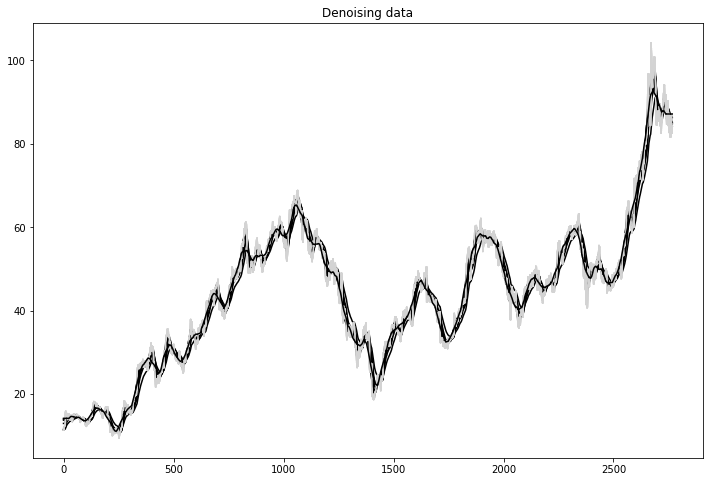

In [92]:
# Note that you need to create a folder with the same name of the Stock
# under the simulation process, i.e., if you are trying to run the code for AMD, 
# you are required to have a folder with the same name, AMD, under the 'Results'
# folder created within the main folder, i.e., Labeling.
Stock = 'STX'
threshholds = [0.1]
Path = 'Results/' + Stock + '/'
methods = ['LSTM', 'GRU', 'XGboost', 'Logreg', 'SVM']
denoiseMethods = ['ewm', 'knn']
values = [12, 20, 26, 50]
days = 44
split_percentatge = 0.7

df = pd.read_csv('Dataset/' + Stock +'.csv', parse_dates=['<DATE>'])
df = df.dropna()
for denoise in denoiseMethods:
  for value in values:
    dfs = df.copy()
    if denoise == 'knn':
      dfs = denoise_data(dfs, '<CLOSE>', k=value)
    else:
      dfs = denoise_data_EWMA(dfs, '<CLOSE>', span=value)
    nrow = dfs.shape[0]
    train_end =round(nrow * split_percentatge) - days
    test_end = nrow - days

    Name = Stock+denoise+str(value)
    for th in threshholds:
        print('Threshhold = ', th)
        true_label = labeling(dfs[col_name], th)
        dfs = dfs.assign(true_labels=pd.Series(true_label).values)
        historical = Train_data(dfs[col_name], train_start=beta + 1, train_end=train_end, test_end=test_end)
        historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
        historical.set_threshold(th=th)
        result = final_result(historical, Name, step_sizes=4, th= th)
        Result_purging = Result_purging.append(result)

    Result_purging.to_csv(Path+Name+'_Result_purging.csv')
        #Result_purging
        
    start = train_end + 10
    end = test_end
    save_pred(start=start, end=end, methods = methods, Path=Path, Name = Name)

In [86]:
# Save predictions 
def save_pred(start, end, methods, Path, Name):
  # LSTM    
    beta = ['','_beta']
    for b in beta:
      if b !='':
        start = train_end + 43
      for method in methods:
        XX = method + b + '_predict'
        X = getattr(historical, XX)
        pred = X
        new_dfs = dfs[start:end].assign(labels=pd.Series(pred).values)
        filename = Path + Name + '_' + method.lower() + b + '_p.csv'
        new_dfs.to_csv(filename)        